In [1]:
import numpy as np

lc = np.genfromtxt("data/PG1302_CRTS.dat", names="mjd, mag, magerr", delimiter=",", skip_header=1)
#print(str(lc['mag']))

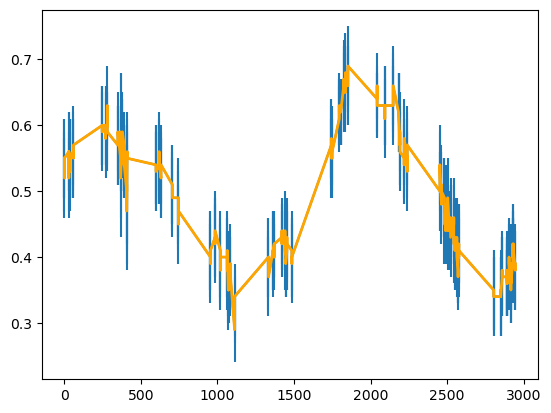

In [2]:
import matplotlib.pyplot as plt

t = lc["mjd"] - lc["mjd"][0]
mag = lc["mag"] - 14.5
magerr = lc['magerr']

plt.plot(t, mag, marker='None', linestyle='-', zorder=1, color='orange', lw=2)
plt.errorbar(t, mag, yerr=magerr, zorder=0)

plt.show()

In [3]:
from scipy.stats import binned_statistic

# Use binned_statistic to calculate mean within each bin
def get_binned_statistic(num_bins, t, mag):
    bin_mag, bin_edges, binnumber = binned_statistic(t, mag, statistic=np.nanmean, bins=num_bins)
    bin_magerr, bin_edges, binnumber = binned_statistic(t, magerr, statistic=np.nanmean, bins=num_bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_t = bin_edges[1:] - bin_width/2

    filter = np.isfinite(bin_mag)
    #print(str(filter[:10]))
    bin_mag = bin_mag[filter]
    bin_t = bin_t[filter]
    bin_magerr = bin_magerr[filter]
    return (bin_t, bin_mag, bin_magerr)
    
#plt.scatter(bin_t, bin_mag)
#plt.show()

num_freq_bins=1000 num_obs_bins=1000
Strongest signal: 0.8940
at freq(1/d):     0.0006
at period(d):     1673.3668
num_freq_bins=1000 num_obs_bins=500
Strongest signal: 0.9039
at freq(1/d):     0.0006
at period(d):     1673.3668
num_freq_bins=100 num_obs_bins=1000
Strongest signal: 0.7847
at freq(1/d):     0.0007
at period(d):     1500.0000
num_freq_bins=100 num_obs_bins=500
Strongest signal: 0.7924
at freq(1/d):     0.0007
at period(d):     1500.0000


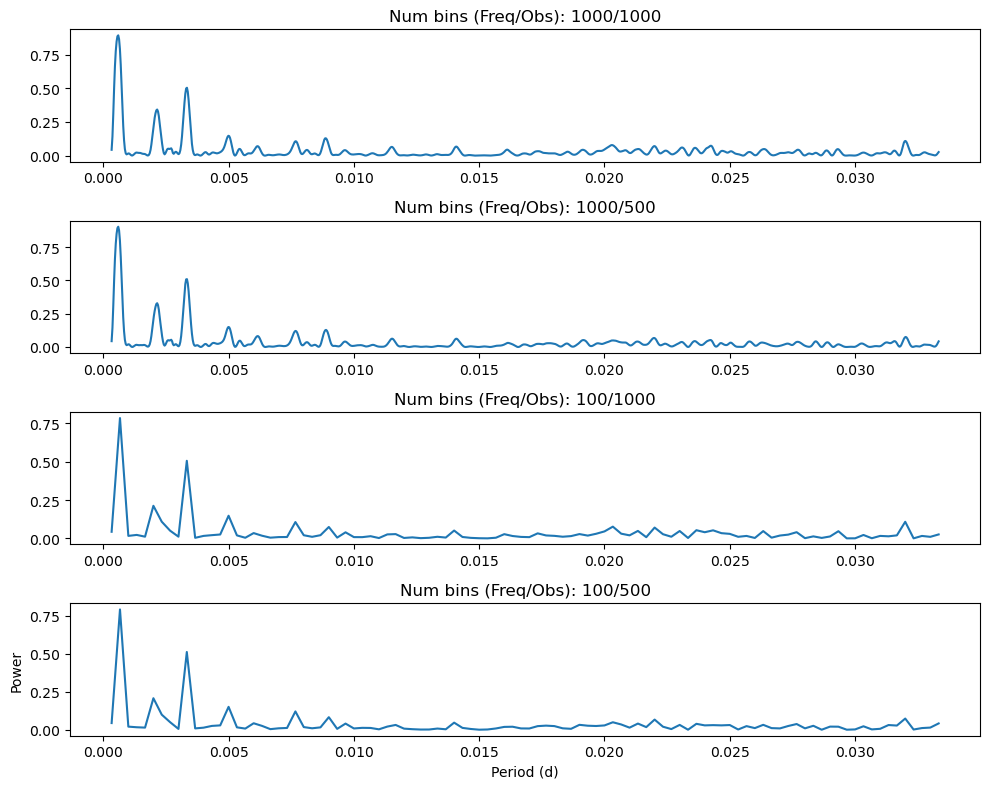

In [17]:
import astropy.units as u
from astropy.timeseries import LombScargle
# Initialise the subplot function using number of rows and columns 
figure, axis = plt.subplots(4, 1, figsize=(10,8)) 
plt.xlabel("Period (d)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram")

for i, num_freq_bins in enumerate([1000, 100]):
    for j, num_obs_bins in enumerate([1000, 500]):
        freqs = np.linspace(1/3000, 1/30,num=num_freq_bins) 
        #print(str(freqs[:10]))
        print("num_freq_bins=" + str(num_freq_bins) + " num_obs_bins=" + str(num_obs_bins))
        bin_t, bin_mag, bin_magerr = get_binned_statistic(num_obs_bins, t, mag)
        #bin_t, bin_mag, bin_magerr = (t, mag, magerr)
    
        #print(str(len(bin_t)) + " : " + str(len(bin_mag)))
        #print(str(bin_t[:10]))
        #print(str(bin_mag[:10]))
        ls = LombScargle(bin_t , bin_mag)
        powers = ls.power(freqs)

        # Find the freq with the strongest signal
        k = np.unravel_index(np.argmax(powers), powers.shape)
        print('Strongest signal: {0:.4f}'.format(powers[k]))
        print('at freq(1/d):     {0:.4f}'.format(freqs[k]))
        print('at period(d):     {0:.4f}'.format(1/freqs[k]))

        axis[i*2+j].plot(freqs, powers) 
        axis[i*2+j].set_title("Num bins (Freq/Obs): " + str(num_freq_bins) + "/" + str(num_obs_bins)) 

plt.tight_layout()
plt.show()
# TODO: Find the FAP (False probability)